In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [2]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [3]:
(train_img,train_class),(test_img,test_class)=tf.keras.datasets.mnist.load_data()

train_img=train_img[(train_class==8) | (train_class==7)]
test_img=test_img[(test_class==8) | (test_class==7)]

height,width=28,28
train_img=train_img.reshape(train_img.shape[0],height,width,1).astype('float32')
train_img/=255

test_img=test_img.reshape(test_img.shape[0],height,width,1).astype('float32')
test_img/=255

train_buffer=60000
test_buffer=10000

batch_size=100
latent_dimensions=32

num=60000
comps=2

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,
                             shear_range=0.0,zoom_range=[1.5,2.5])

gen=datagen.flow(train_img,None,batch_size=1)

components=np.array([[gen.next()[0, ..., 0] for j in range(num)] for i in range(comps)])
blended=components.sum(axis=0)
together=np.array((blended,components[0],components[1]))

In [9]:
np.save('blended_set',together)

In [11]:
together=np.load('blended_set.npy')
blended,components=together[0],np.array((together[1],together[2]))
blended.shape,components.shape

((60000, 28, 28), (2, 60000, 28, 28))

In [12]:
blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components=components.reshape(2,blended.shape[0],height,width,1).astype('float32')

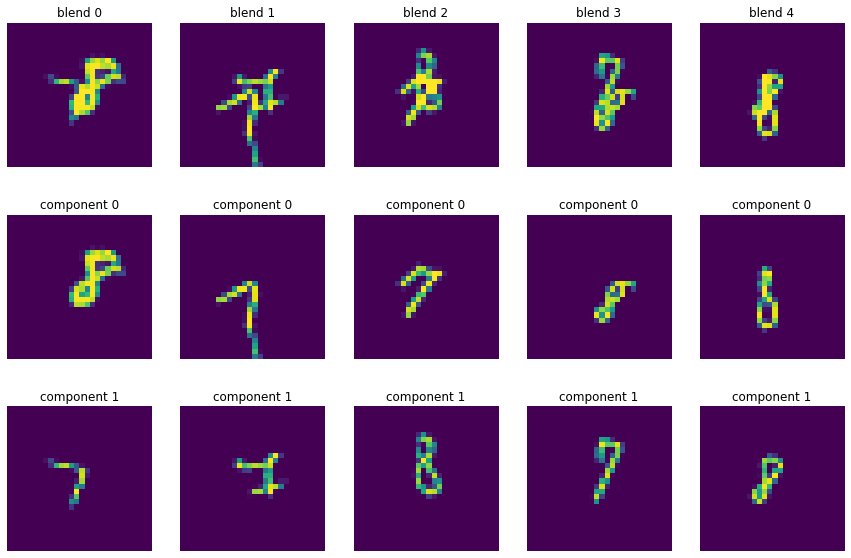

In [13]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [14]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    #x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [15]:
def decoder(x):
    #x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [16]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [17]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

embed2=Dense(np.prod(shape),activation='relu')(input_embed)
embed2=Reshape(shape)(embed2)
decoded2=decoder(embed2)
output2=Conv2DTranspose(1,3,padding='same')(decoded2)

In [18]:
encode=Model(inputs,z)
encode.summary()

input_comp1=Input(shape=(height,width,1))
input_comp2=Input(shape=(height,width,1))

decode=Model([input_embed,input_comp1,input_comp2],[output1,output2])
decode.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [19]:
encoding=encode(inputs) #define the network
re1,re2=decode([encoding,input_comp1,input_comp2])

vae=Model([inputs,input_comp1,input_comp2],[re1,re2]) #adds methods of the network
vae.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 32)           219584      input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
_______________________________________________________________________________________

In [20]:
mse_loss1=tf.reduce_mean((mse(input_comp1,re1)+mse(input_comp2,re2))/2,axis=(1,2))
mse_loss2=tf.reduce_mean((mse(input_comp2,re1)+mse(input_comp1,re2))/2,axis=(1,2))
mse_loss=tf.reduce_mean(tf.minimum(mse_loss1,mse_loss2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

beta=0.1
kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0],components[1]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [21]:
history=vae.fit(together,verbose=1,epochs=5,batch_size=batch_size)

Epoch 1/5
600/600 [==============================] - 50s 84ms/step - loss: 9.7526 - mse_loss: 9.5388 - kl_loss: 0.2139
Epoch 2/5
600/600 [==============================] - 51s 86ms/step - loss: 6.9748 - mse_loss: 6.7082 - kl_loss: 0.2666
Epoch 3/5
600/600 [==============================] - 49s 82ms/step - loss: 6.4535 - mse_loss: 6.1803 - kl_loss: 0.2732
Epoch 4/5
600/600 [==============================] - 49s 82ms/step - loss: 6.1482 - mse_loss: 5.8708 - kl_loss: 0.2774
Epoch 5/5
600/600 [==============================] - 52s 86ms/step - loss: 5.9383 - mse_loss: 5.6580 - kl_loss: 0.2802


In [22]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    comp1,comp2=inputs[1][idx],inputs[2][idx]
    z = encode.predict(input_img)
    output_img1,output_img2 = decode.predict([z,comp1,comp2])
    fig, ax = plt.subplots(6, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(comp1[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(comp2[i], ax[2, i], f'comp2 {idx[i]}')
        showimg(output_img1[i], ax[3, i], f'output1\n{encoding}')
        showimg(output_img2[i], ax[4, i], f'output2\n{encoding}')
        showimg(output_img1[i] + output_img2[i], ax[5, i], f'outblend\n{encoding}')
    return idx

[15281 21435 44536 13518 47529]


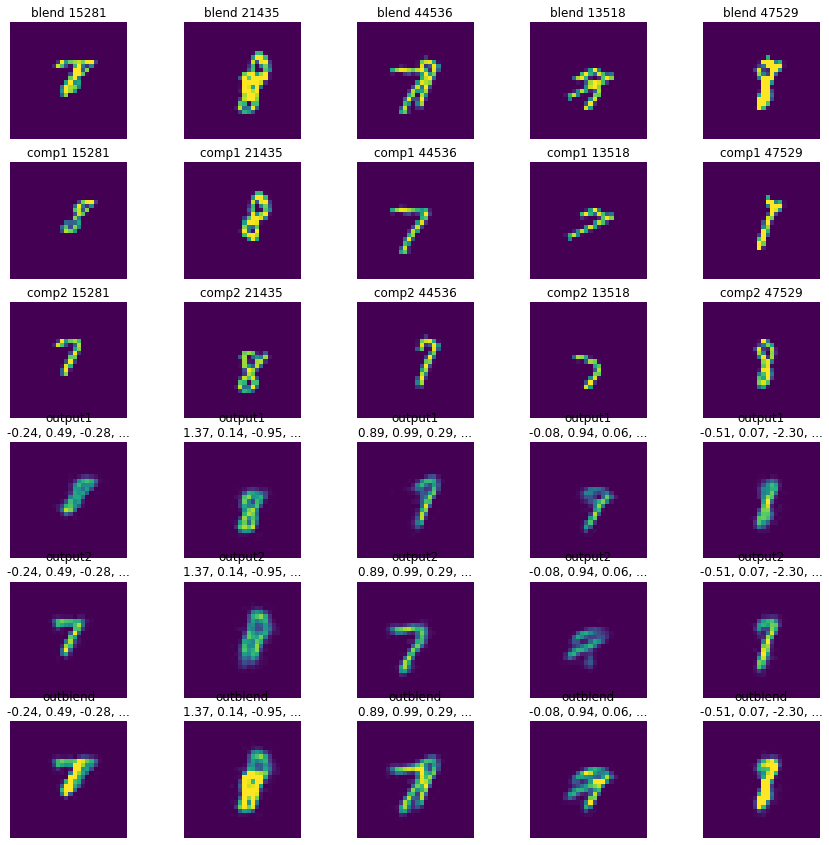

In [23]:
chosen=summary_plot(n,together,decode)

In [ ]:
for layer in decoder.layers
    layer.trainable=false
    
#input blended image + central component (image always with galaxy at centre) (maybe with coord of peak)
#compute loss using central component